<a href="https://colab.research.google.com/gist/KhawajaMuddassar/dfbf9a9955cb8cb4330c12c561e53fcd/imageretrival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image retrieval using pretrained CLIP**

In [2]:
# Install Required Packages
!pip install -q  ipywidgets transformers sentance-transformers torch torchvision
!pip install -q -U flax

#Import Required Libraries
import os, sys, json, zipfile, natsort, numpy as np, pandas as pd, transformers, torch, torchvision, glob
from transformers import AutoTokenizer
from IPython.display import display, Image
from PIL import Image as PilImage
from glob import glob
from torchvision import transforms
from torchvision.transforms import CenterCrop, ConvertImageDtype, Normalize, Resize, ToTensor
from torchvision.transforms.functional import InterpolationMode
from tqdm.notebook import tqdm
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# FlaxHybridCLIP class let's us load any text and vision encoder model to create a dual encoder
!wget -N -q  https://github.com/huggingface/transformers/raw/master/examples/research_projects/jax-projects/hybrid_clip/modeling_hybrid_clip.py
!wget -N -q https://github.com/huggingface/transformers/raw/master/examples/research_projects/jax-projects/hybrid_clip/configuration_hybrid_clip.py
sys.path.append('.')
from modeling_hybrid_clip import FlaxHybridCLIP

# Download and extract MSCOCO dataset for image captioning in italian
!git clone https://github.com/crux82/mscoco-it/
!wget -N -q --show-progress http://images.cocodataset.org/zips/val2014.zip
!gunzip /content/mscoco-it/mscoco-it/captions_ita_devset_validated.json.gz
!gunzip /content/mscoco-it/mscoco-it/captions_ita_devset_unvalidated.json.gz

img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)
with zipfile.ZipFile("val2014.zip", 'r') as zf:
    for member in tqdm(zf.infolist(), desc='Extracting'):
        zf.extract(member, img_folder)
with open("/content/mscoco-it/mscoco-it/captions_ita_devset_unvalidated.json") as filino:
    data = json.load(filino)["annotations"]
def get_path_coco(image_id):
    image_id = int(image_id)
    return f"photos/val2014/COCO_val2014_{image_id:012d}.jpg"

ERROR: Could not find a version that satisfies the requirement sentance-transformers (from versions: none)
ERROR: No matching distribution found for sentance-transformers
Cloning into 'mscoco-it'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 34 (delta 6), reused 19 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 20.64 MiB | 43.22 MiB/s, done.
Resolving deltas: 100% (6/6), done.
val2014.zip         100%[===================>]   6.19G  49.3MB/s    in 2m 3s   


Extracting:   0%|          | 0/40505 [00:00<?, ?it/s]

### Image Preprocessing

Clean up image files by deleting images that are not part of a predefined list of "good" images.

1. Generate Good Image List:
2. Retrieve All Image Paths in a Folder  
3. Identify Images to Delete
4. Delete Unwanted Images

In [3]:
import glob
good_images = [get_path_coco(d["image_id"]) for d in data]
img_names = list(glob.glob('photos/val2014/*.jpg'))
destroy_images = set(img_names).difference(set(good_images))

for img in destroy_images:
    os.remove(img)

### Load Models

Loads and manages different models based on the value of the `MODEL_TYPE` variable. The two supported model types are `'mClip'` for multilingual CLIP models and `'clip_italian'` for a specific Italian CLIP model.

1. MODEL_TYPE == 'mClip'
2. MODEL_TYPE == 'clip_italian'

In [5]:
from transformers import FlaxVisionTextDualEncoderModel, VisionTextDualEncoderModel

#MODEL_TYPE = 'mClip'
MODEL_TYPE = 'clip_italian'

if MODEL_TYPE == 'mClip':
    from sentence_transformers import SentenceTransformer
    # Here we load the multilingual CLIP model. Note, this model can only encode text.
    # If you need embeddings for images, you must load the 'clip-ViT-B-32' model
    se_language_model = SentenceTransformer('clip-ViT-B-32-multilingual-v1')
    se_image_model = SentenceTransformer('clip-ViT-B-32')
    language_model = lambda queries: se_language_model.encode(queries, convert_to_tensor=True, show_progress_bar=False).cpu().detach().numpy()
    image_model = lambda images: se_image_model.encode(images, batch_size=1024, convert_to_tensor=True, show_progress_bar=False).cpu().detach().numpy()
elif MODEL_TYPE == 'clip_italian':
    import jax
    from jax import numpy as jnp
    TOKENIZER_NAME = "dbmdz/bert-base-italian-xxl-uncased"
    tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, cache_dir=None, use_fast=True)
    model = FlaxVisionTextDualEncoderModel.from_pretrained("clip-italian/clip-italian", logit_scale_init_value=1)
    def tokenize(texts):
        inputs = tokenizer(texts, max_length=96, padding="max_length", return_tensors="np")
        return inputs['input_ids'], inputs['attention_mask']

    language_model = lambda queries: np.asarray(model.get_text_features(*tokenize(queries)))
    image_model = lambda images: np.asarray(model.get_image_features(images.permute(0, 2, 3, 1).numpy(),))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/243k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.37k [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/796M [00:00<?, ?B/s]

# **Utils Functions**


In [6]:
# 1: Image Dataset (CustomDataSet):
    # Loads and manages images stored in a directory.
    # It applies a transformation to each image and returns the transformed image as a tensor when requested.
class CustomDataSet(torch.utils.data.Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)
    def __len__(self):
        return len(self.total_imgs)
    def get_image_name(self, idx):
        return self.total_imgs[idx]
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = PilImage.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

# 2: Text Dataset (SimpleTextDataset):
    # Loads and manages a collection of text data. It returns individual text samples when requested.
class SimpleTextDataset(torch.utils.data.Dataset):
    def __init__(self, texts):
        self.texts = texts
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return self.texts[idx]

# 3: Text Encoder (text_encoder):
    # Encodes a given text query into an embedding (feature vector) using the language_model. The embedding is normalized (L2 norm).
def text_encoder(text):
    # inputs = tokenizer([text], max_length=96, truncation=True, padding="max_length", return_tensors="np")
    # embedding = model.get_text_features(inputs['input_ids'], inputs['attention_mask'])[0]
    embedding = language_model(text)
    embedding = embedding / np.linalg.norm(embedding)
    return embedding

# 4: Precomputing Text Features (precompute_text_features):
    # Computes and stores embeddings for all the texts in a dataset. These embeddings are normalized and returned as an array.
def precompute_text_features(loader):
    text_features = []
    for i, (texts) in enumerate(tqdm(loader)):
        # inputs = tokenizer(texts, max_length=96, truncation=True, padding="max_length", return_tensors="np")
        # embedding = model.get_text_features(inputs['input_ids'], inputs['attention_mask'])
        # embedding /= jnp.linalg.norm(embedding, axis=1, keepdims=True)
        embedding = language_model(texts)
        embedding = embedding / np.linalg.norm(embedding)
        text_features.extend(embedding)
    return np.array(text_features)

# 5: Precomputing Image Features (precompute_image_features):
    # Computes and stores embeddings for all the images in a dataset. These embeddings are normalized and returned as an array.
def precompute_image_features(loader):
    image_features = []
    for i, (images) in enumerate(tqdm(loader)):
        # images = images.permute(0, 2, 3, 1).numpy()
        # features = model.get_image_features(images,)
        features =image_model(images)
        features = features / np.linalg.norm(features, axis=1, keepdims=True)
        image_features.extend(features)
    return np.array(image_features)

# 6: Text-to-Image Search (find_image):
    # Given a text query, this function computes its embedding and compares it to the precomputed image embeddings to find the most similar images.
    # It returns the paths of the top n most similar images.
def find_image(text_query, datatset, image_features, n=1):
    zeroshot_weights = text_encoder(text_query)
    zeroshot_weights = zeroshot_weights / np.linalg.norm(zeroshot_weights)
    distances = np.dot(image_features, zeroshot_weights.reshape(-1, 1))
    file_paths = []
    for i in range(1, n+1):
        idx = np.argsort(distances, axis=0)[-i, 0]
        file_paths.append('photos/val2014/' + dataset.get_image_name(idx))
    return file_paths

# 7: Displaying Images
def show_images(image_list):
    for im_path in image_list:
        display(Image(filename=im_path))

# **Model Processing**
- **Image Preprocessing**: Images are resized, cropped, and normalized to ensure they are in the correct format for the model.
- **Dataset Loading**: Both images and text are loaded into custom datasets (**CustomDataSet** for images and **SimpleTextDataset** for text).
- **Efficient Batch Processing**: The **DataLoader** objects for efficient batch loading of images and text.


In [7]:
image_size = 224

val_preprocess = transforms.Compose([
    Resize([image_size], interpolation=InterpolationMode.BICUBIC),
    CenterCrop(image_size),
    ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),])

dataset = CustomDataSet("photos/val2014", transform=val_preprocess)
text_dataset = SimpleTextDataset([elem["caption"] for elem in data])
loader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=1024,
                    shuffle=False,
                    num_workers=2,
                    persistent_workers=True,
                    drop_last=False)
text_loader = torch.utils.data.DataLoader(
                    text_dataset,
                    batch_size=1024,
                    shuffle=False)

# **Precomputation**

Precompute the feature embeddings for both the images and texts (captions) in the dataset. These embeddings will later be used for various tasks like similarity comparison, text-to-image retrieval.


In [8]:
image_features = precompute_image_features(loader)
text_features = precompute_text_features(text_loader)

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/9 [00:00<?, ?it/s]

# **Evaluation Metrics**

Computes two common evaluation metrics—**Mean Reciprocal Rank (MRR)** and **Hits@N**—for a text-to-image retrieval task. The goal is to evaluate how well a model retrieves the correct image for a given text (caption).


- **MRR**: Measures the rank of the first correct result. If the correct image is ranked 1st, the reciprocal rank is 1; if it’s ranked 2nd, it’s 0.5, and so on.
- **Hits@N**: Measures whether the correct image appears in the top `n` results. It returns 1 if the correct image is in the top `n` and 0 if it is not.


In [9]:
def compute_mrr(data, dataset, n):
    collect_rr = []
    pbar = tqdm(total=len(data), position=0, leave=True)
    found = np.matmul(text_features, image_features.T)
    for index, distances in enumerate(found):
        pbar.update(1)
        image_path = get_path_coco(data[index]["image_id"])
        collect_rr.append(new_rr(distances, image_path, dataset, n))
    pbar.close()
    return np.average(collect_rr)

def new_rr(distances, target_image, dataset, n):
    image_paths = []
    idxs = distances.argsort()[-n:][::-1]
    for idx in idxs:
        image_paths.append('photos/val2014/' + dataset.get_image_name(idx))
    if target_image in image_paths:
        return 1/(image_paths.index(target_image) + 1)
    else:
        return 0
    return 1/rank

def internal_hits(distances, target_image, dataset, n):
    image_paths = []
    idxs = distances.argsort()[-n:][::-1]
    for idx in idxs:
        image_paths.append('photos/val2014/' + dataset.get_image_name(idx))
    if target_image in image_paths:
        return 1
    else:
        return 0

def compute_hits(data, dataset, n):
    collect_rr = []
    pbar = tqdm(total=len(data), position=0, leave=True)
    found = np.matmul(text_features, image_features.T)
    for index, distances in enumerate(found):
        pbar.update(1)
        image_path = get_path_coco(data[index]["image_id"])
        collect_rr.append(internal_hits(distances, image_path, dataset, n))
    pbar.close()
    return np.average(collect_rr)

print('MRR@1:', compute_mrr(data, dataset, 1))
print('MRR@5:', compute_mrr(data, dataset, 5))
print('MRR@10:', compute_mrr(data, dataset, 10))
print(compute_hits(data, dataset, 100)) #Hits@100 score, higher score indicates better retrieval performance

  0%|          | 0/8486 [00:00<?, ?it/s]

MRR@1: 0.3796841857176526


  0%|          | 0/8486 [00:00<?, ?it/s]

MRR@5: 0.5038907219734464


  0%|          | 0/8486 [00:00<?, ?it/s]

MRR@10: 0.5203983966121604


  0%|          | 0/8486 [00:00<?, ?it/s]

0.9913975960405373


# **Inference**

In [18]:
data[200]["caption"]

'Un tavolo da pranzo con diverse sedie intorno ad esso.'

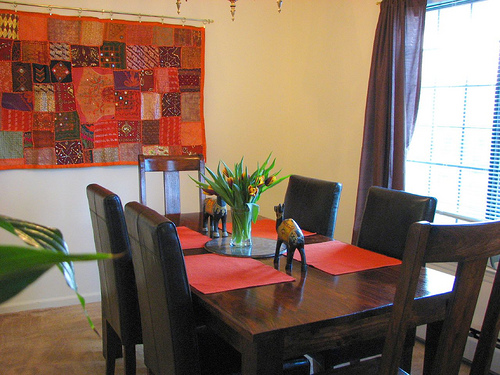

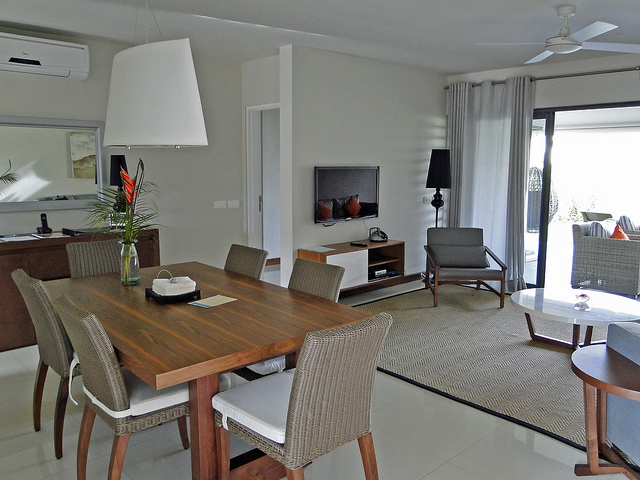

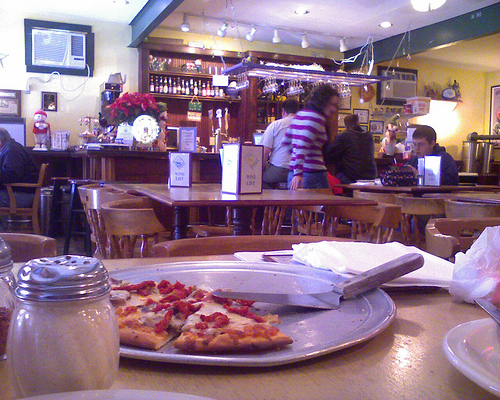

In [20]:
text = "Un tavolo da pranzo con diverse sedie intorno ad esso."

image_paths = find_image(text, dataset, image_features, n=3)
show_images(image_paths)